In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 13989371.03it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 682977.91it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 7315268.48it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12658158.65it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [8]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [12]:
opt = optim.SGD(model_dnn_2.parameters(), lr=0.01)

print(*(i.format(i) for i in ("train_err", "train_loss", "test_err", "test_loss")), sep="\t")
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

train_err	train_loss	test_err	test_loss
0.082133	0.290768	0.077400	0.275992
0.079600	0.282681	0.075400	0.268178
0.077500	0.275034	0.073300	0.262209
0.075683	0.267997	0.072000	0.255490
0.073933	0.261022	0.071400	0.250769
0.071850	0.254867	0.069200	0.243756
0.070300	0.248727	0.068000	0.239045
0.068350	0.242922	0.066600	0.234063
0.066700	0.237447	0.065500	0.229359
0.065067	0.232217	0.064200	0.224548


In [14]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)

print(*(i.format(i) for i in ("train_err", "train_loss", "test_err", "test_loss")), sep="\t")
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

train_err	train_loss	test_err	test_loss
0.095500	0.315798	0.066200	0.224066
0.052300	0.177300	0.042800	0.141382
0.036783	0.122731	0.035500	0.113192
0.028967	0.095868	0.029700	0.092816
0.022850	0.075734	0.030500	0.093257
0.019150	0.063720	0.032000	0.096065
0.016450	0.054179	0.023400	0.076288
0.013467	0.045120	0.022200	0.075256
0.011600	0.038799	0.022000	0.076150
0.009633	0.031980	0.027300	0.087959


In [15]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)

print(*(i.format(i) for i in ("train_err", "train_loss", "test_err", "test_loss")), sep="\t")
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

train_err	train_loss	test_err	test_loss
0.240533	0.687054	0.031300	0.094874
0.026333	0.084593	0.020200	0.065680
0.016300	0.053807	0.017100	0.047735
0.012600	0.040287	0.013400	0.043086
0.010100	0.031824	0.014300	0.043437
0.004083	0.014850	0.010800	0.036316
0.003083	0.011258	0.011000	0.036055
0.002683	0.009848	0.011000	0.036798
0.002350	0.008813	0.010800	0.037943
0.001933	0.008000	0.010700	0.038210


In [16]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [17]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

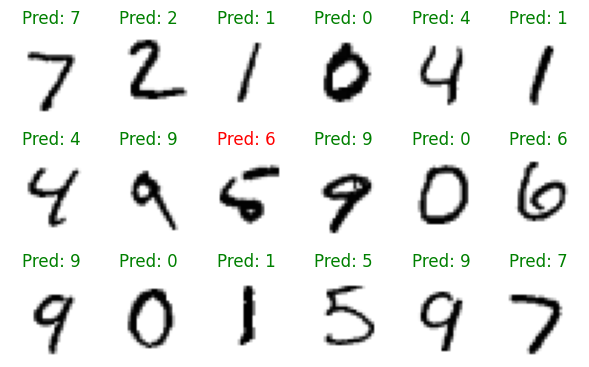

In [18]:
### Illustrate original predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

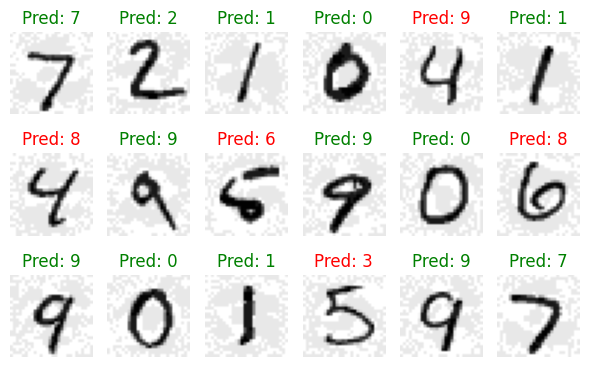

In [23]:
### Illustrate attacked images
delta_dnn_2 = fgsm(model_dnn_2, X, y, 0.05)
yp = model_dnn_2(X + delta_dnn_2)
plot_images(X+delta_dnn_2, y, yp, 3, 6)

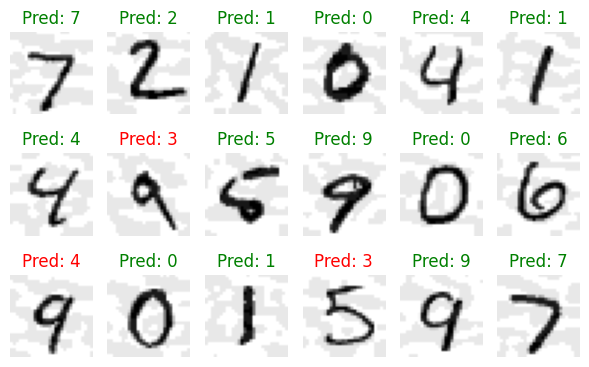

In [24]:
### Illustrate attacked images
delta_cnn = fgsm(model_cnn, X, y, 0.05)
yp = model_cnn(X + delta_cnn)
plot_images(X+delta_cnn, y, yp, 3, 6)


In [28]:
def plot_deltas(X,M,N, title):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    plt.suptitle(title)
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            ax[i][j].set_axis_off()
    plt.tight_layout()

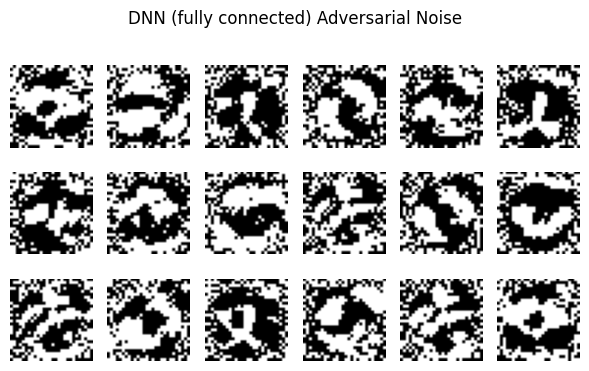

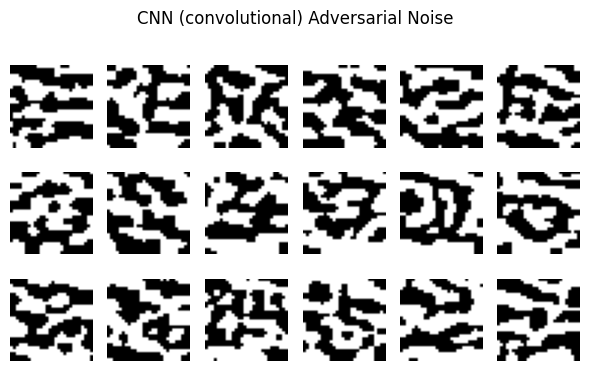

In [29]:
plot_deltas(delta_dnn_2, 3, 6, "DNN (fully connected) Adversarial Noise")
plot_deltas(delta_cnn, 3, 6, "CNN (convolutional) Adversarial Noise")

In [30]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [32]:
print("2-layer DNN Error:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN Error:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN Error:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN Error: 0.9077
4-layer DNN Error: 0.9495
        CNN Error: 0.4785


In [33]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

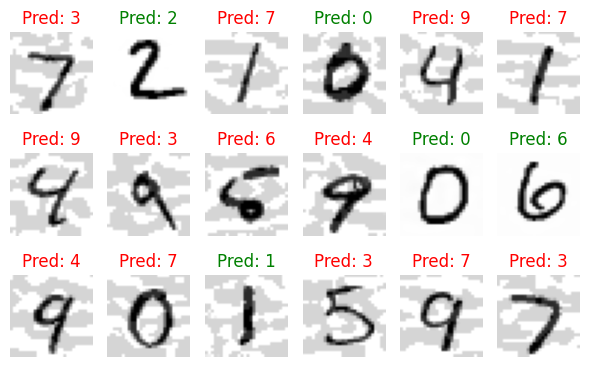

In [34]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [35]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

7.12533028490725e-06


In [36]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

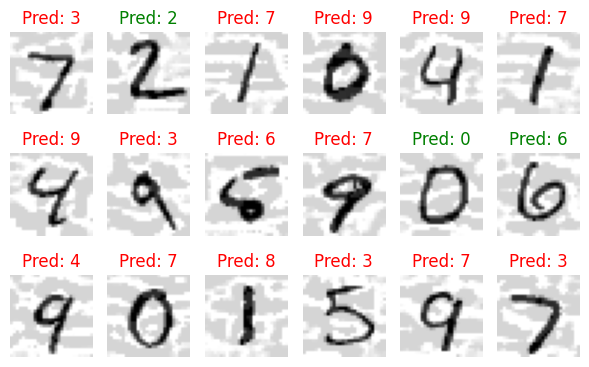

In [37]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [38]:
print("2-layer DNN Error:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN Error:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("        CNN Error:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN Error: 0.9437
4-layer DNN Error: 0.9957
        CNN Error: 0.7535


In [39]:
def stochastic_pgd_linf(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [41]:
print("2-layer DNN Error:", epoch_adversarial(model_dnn_2, test_loader, stochastic_pgd_linf, 0.1, 1e-2, 40, 10)[0])
print("4-layer DNN Error:", epoch_adversarial(model_dnn_4, test_loader, stochastic_pgd_linf, 0.1, 1e-2, 40, 10)[0])
print("        CNN Error:", epoch_adversarial(model_cnn, test_loader, stochastic_pgd_linf, 0.1, 1e-2, 40, 10)[0])

2-layer DNN Error: 0.9465
4-layer DNN Error: 0.9968
        CNN Error: 0.7723
